# About this notebook
In this notebook, we introduce the overall flow of predicting bandgaps from crystal structures using the fine-tuned LLM (`ysuz/Mistral-Nemo-Base-2407-bandgap`).

If you are running this notebook in Google Colab or in your own environment, please place the [train_structure2property.py](https://github.com/resnant/llm4mat-tutorial/blob/main/train_structure2property.py) file in the same directory as this notebook, or refer to its contents and copy and paste the necessary functions (load_mp_pickles, get_structure_info_text, prepare_datasets) into the notebook cells.

In [1]:
import os
import sys
sys.path.append("/workspace")

import json
import glob
import pickle
from tqdm import tqdm
from multiprocessing import Pool
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import Dataset
import torch
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

from train_structure2property import load_mp_pickles, get_structure_info_text, prepare_datasets

def parse_llm_output(output_text):
    try:
        result_val = float(output_text.split("Output:\n")[-1])
    except:
        result_val= None
    return result_val

2024-07-24 10:50:14.886461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 10:50:14.900820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 10:50:14.905200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 10:50:14.915864: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 10:50:16.270456: W tensorflow/compiler/tf2

[2024-07-24 10:50:17,634] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.2
 [WARNING]  using untested triton version (2.2.0), only 1.0.0 is known to be compatible


In [ ]:
mp_data = load_mp_pickles("../mp_download")    # tokenizer, model = setup_tokenizer_and_model(model_id = "mistralai/Mixtral-8x7B-v0.1")
dataset_split = prepare_datasets(mp_data, "band_gap")

model_id = "ysuz/Mistral-Nemo-Base-2407-bandgap"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map="auto",
                                             torch_dtype=torch.float16,
                                             # load_in_8bit=True # please use this option instead of torch_dtype=torch.float16 to reduce memory usage
                                         )

In [3]:
# example of input context and generation result

structure_text = """
Reduced Formula: BaSrI4
abc   :   5.807091   5.807091   8.251028
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
space group: ('P4/mmm', 123)
Sites (6)
  #  SP      a    b         c    magmom
  0  Ba    0.5  0.5  0               -0
  1  Sr    0    0    0.5             -0
  2  I     0    0.5  0.257945         0
  3  I     0.5  0    0.257945         0
  4  I     0    0.5  0.742055         0
  5  I     0.5  0    0.742055         0

Output:
"""

prompt = f"Instruction: What is the bandgap value of following material?:\n{structure_text}\n\nOutput:\n"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    tokens = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.5,
        top_p=0.9,
        repetition_penalty=1.05,
    )
generated_text = tokenizer.decode(tokens[0], skip_special_tokens=True)
print(f"Generated raw text:\n{generated_text}\n\n")

parsed_text = parse_llm_output(generated_text)
print("- - - - - - - - - - - - -")
print(f"Parsed result: {parsed_text} eV")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated raw text:
Instruction: What is the bandgap value of following material?:

Reduced Formula: BaSrI4
abc   :   5.807091   5.807091   8.251028
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
space group: ('P4/mmm', 123)
Sites (6)
  #  SP      a    b         c    magmom
  0  Ba    0.5  0.5  0               -0
  1  Sr    0    0    0.5             -0
  2  I     0    0.5  0.257945         0
  3  I     0.5  0    0.257945         0
  4  I     0    0.5  0.742055         0
  5  I     0.5  0    0.742055         0

Output:


Output:
3.4937


- - - - - - - - - - - - -
Parsed result: 3.4937 eV


In [4]:
# example of input context
i = 4
structure_text = dataset_split["test"][i]["structure"]
target = dataset_split["test"][i]["target"]
prompt = f"Instruction: What is the bandgap value of following material?:\n{structure_text}\n\nOutput:\n{target}"

print(prompt)

Instruction: What is the bandgap value of following material?:
Reduced Formula: BaSrI4
abc   :   5.807091   5.807091   8.251028
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
space group: ('P4/mmm', 123)
Sites (6)
  #  SP      a    b         c    magmom
  0  Ba    0.5  0.5  0               -0
  1  Sr    0    0    0.5             -0
  2  I     0    0.5  0.257945         0
  3  I     0.5  0    0.257945         0
  4  I     0    0.5  0.742055         0
  5  I     0.5  0    0.742055         0

Output:
3.2021999999999995


In [5]:
# batch inference on test dataset

generated_data = [] 

for mat_idx, structure_text in tqdm(enumerate([material["structure"] for material in dataset_split["test"]][::100])): # sample 1% of dataset
    prompt = f"Instruction: What is the bandgap value of following material?:\n{structure_text}\n\nOutput:\n"
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        tokens = model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=True,
            temperature=0.5,
            top_p=0.9,
            repetition_penalty=1.05,
            pad_token_id=tokenizer.pad_token_id,
        )
    generated_text = tokenizer.decode(tokens[0], skip_special_tokens=True)
    parsed_text = parse_llm_output(generated_text)
    
    generated_data.append({"mat_idx": mat_idx, "structure_text": structure_text, "output": generated_text, "parsed_text":parsed_text})

pred_values = [dt["parsed_text"] for dt in generated_data]
true_values = [material["target"] for material in dataset_split["test"]][::100] # sample 1% of dataset

127it [00:27,  4.57it/s]


R2 Score: 0.7923199390551515
Mean Absolute Error: 0.3578055118110236 eV


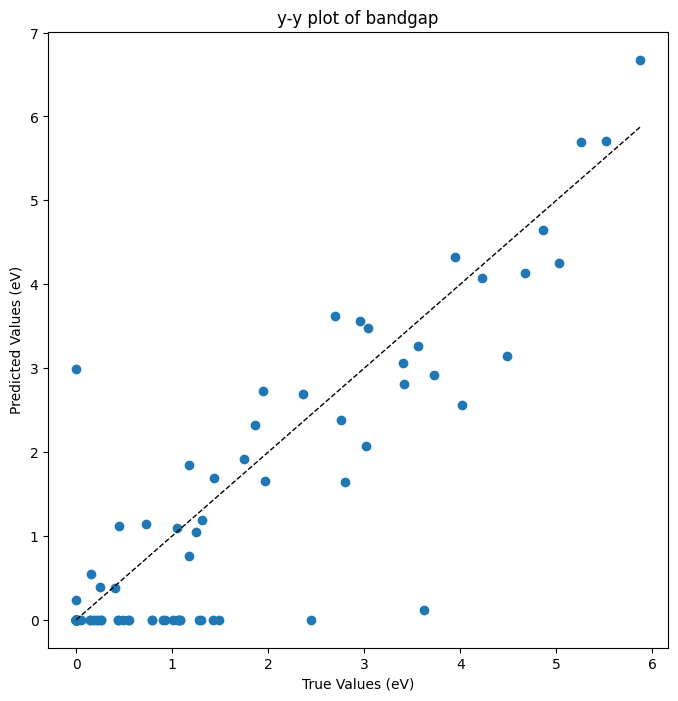

In [6]:
r2 = r2_score(true_values, pred_values)
mae = mean_absolute_error(true_values, pred_values)
print(f'R2 Score: {r2}')
print(f'Mean Absolute Error: {mae} eV')

plt.figure(figsize=(8, 8))
plt.scatter(true_values, pred_values)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'k--', lw=1)
plt.xlabel('True Values (eV)')
plt.ylabel('Predicted Values (eV)')
plt.title('y-y plot of bandgap')
plt.show()

## Note
When considering the current top-tier DNN models, which are primarily based on graph neural networks, they achieve an approximate MAE of 0.2 eV for bandgap prediction (Table 1). Therefore, our performance (MAE = 0.36 eV) is promising as an initial result with large language models.

This table is taken from our recent work, [Crystalformer: Infinitely Connected Attention for Periodic Structure Encoding](https://omron-sinicx.github.io/crystalformer/)

![materials property prediction benchmarking](https://omron-sinicx.github.io/crystalformer/assets/benchmark.png)

